<a href="https://colab.research.google.com/github/ainizamova/ASR_CourseWork/blob/main/en_speech_2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Импортирование и установки**

In [ ]:
# Установка зависимостей
!pip install wget
!apt-get install sox libsndfile1 ffmpeg libsox-fmt-mp3
!pip install unidecode
!pip install matplotlib>=3.3.2
#!pip install --upgrade numba

# Установка NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=2af9eab5999a2f066dc66e6171dd4edb8744697bc7df48bf48c480c0ee535f1b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following additional packages will be installed:
  libid3tag0 libmad0 libmagic-mgc libmagic1 libopencore-amrnb0
  libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libid3tag0 libmad0 libmagic-mgc libmagic1 libopencore-amrnb0
  libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox-fmt-mp3 libsox3
  sox
0 upgraded, 11 newly installed, 0 to remove and 39 not upgraded.
Need to get 872 kB of archi

In [ ]:
# Импорт NeMo
import nemo
# Импорт коллекции по распознаванию речи
import nemo.collections.asr as nemo_asr
# для прослушивания аудио
import IPython
from nemo.collections.asr.metrics.wer import WER, word_error_rate

#from omegaconf import DictConfig, OmegaConf
#from nemo.utils.exp_manager import exp_manager

[NeMo W 2022-04-20 06:55:50 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [ ]:
# необходимо для RNNT моделей
!pip install --upgrade numba --ignore-installed

     |████████████████████████████████| 3.3 MB 5.5 MB/s 
     |████████████████████████████████| 1.1 MB 39.9 MB/s 
     |████████████████████████████████| 15.7 MB 41.8 MB/s 
     |████████████████████████████████| 34.5 MB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Подготовка данных**

In [ ]:
!pwd

/content


In [ ]:
# Будем располагать данные в текущей директории
data_dir = '.'

In [ ]:
import glob
import os
import subprocess
import wget
import zipfile
from zipfile import ZipFile 

In [ ]:
# Если что-то пойдет не так во время обработки данных, раскомментируйте следующую строку, чтобы удалить кэшированный набор данных 
#!rm -rf datasets/...
!mkdir -p datasets/my_en_audio

In [ ]:
import librosa
import IPython.display as ipd
# Загрузка и прослушивание аудиофайла
example_file = data_dir + '/datasets/my_en_audio/006.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

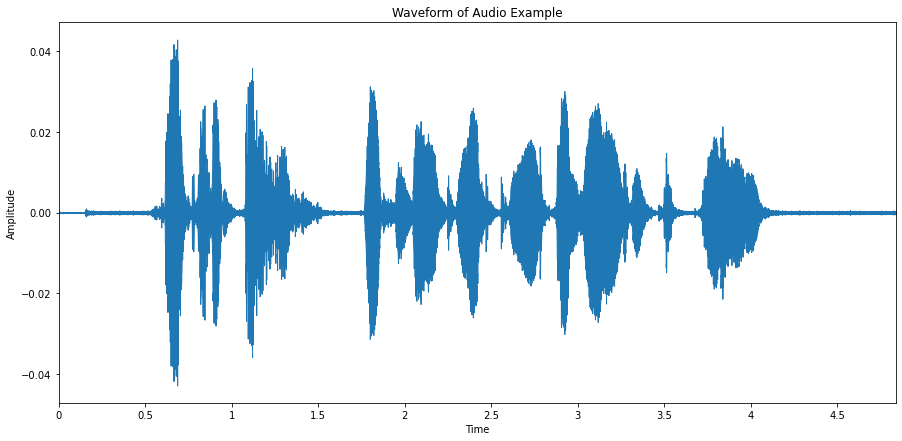

In [ ]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveplot(audio)

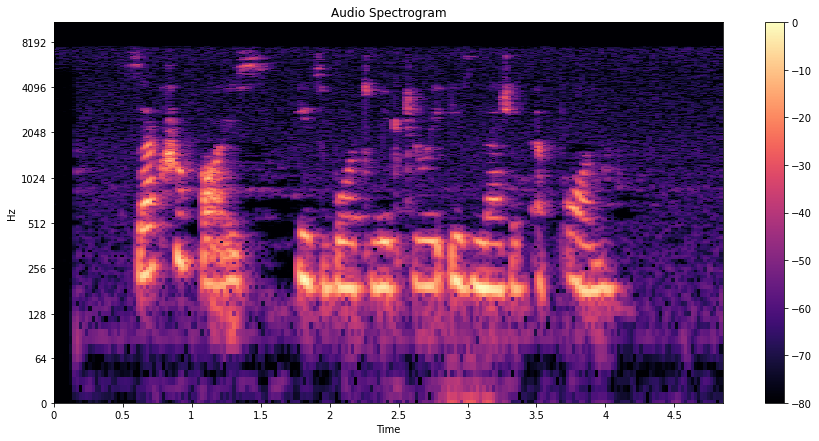

In [ ]:
import numpy as np

# Спектрограмма через кратковременное преобразование Фурье Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Децибел

# Для просмотра частот используем логарифмическую шкалу
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

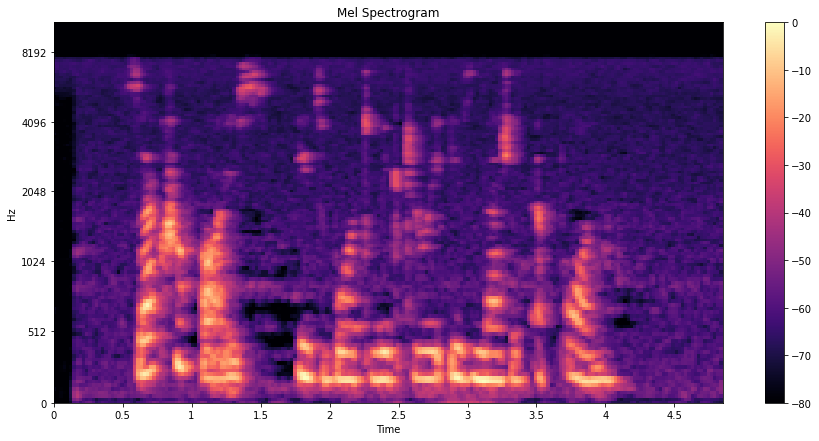

In [ ]:
# Мел-спектрограмма

mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

In [ ]:
import json

# Функция для создания манифест-файлов
def build_manifest(transcripts_path, manifest_name, wav_path):
    with open(transcripts_path, 'r') as fin:
        with open(manifest_name, 'w') as fout:
            for line in fin:
                transcript = line[line.find(':')+1 : ].lower()
                transcript = transcript.strip() 

                file_id = line[ : line.find(':')]  # напр., "019"
                audio_path = os.path.join(wav_path,
                    file_id + '.wav')

                duration = librosa.core.get_duration(filename=audio_path)

                # запишем метаданные в манифест
                metadata = {
                    "audio_filepath": audio_path,
                    "duration": duration,
                    "text": transcript
                }
                json.dump(metadata, fout)
                fout.write('\n')
                
# Создание манифест-файла
print("******")
test_transcripts = data_dir + '/datasets/transcription.txt'
test_manifest = data_dir + '/test_manifest.json'
wav_path = data_dir + '/datasets/my_en_audio'

if not os.path.isfile(test_manifest):
    build_manifest(test_transcripts, "test_manifest.json" , wav_path)
    print("Test manifest created.")
print("***Done***")

******
Test manifest created.
***Done***


In [ ]:
from collections import defaultdict
from tqdm.auto import tqdm

# функция для получения символов, используемых в тексте
def get_charset(manifest_data):
    charset = defaultdict(int)
    for row in tqdm(manifest_data, desc="Computing character set"):
        text = row['text']
        for character in text:
            charset[character] += 1
    return charset

In [ ]:
def read_manifest(path):
    manifest = []
    with open(path, 'r') as f:
        for line in tqdm(f, desc="Reading manifest data"):
            line = line.replace("\n", "")
            data = json.loads(line)
            manifest.append(data)
    return manifest

In [ ]:
# функция для записи обработанного манифеста
def write_processed_manifest(data, original_path):
    original_manifest_name = os.path.basename(original_path)
    new_manifest_name = original_manifest_name.replace(".json", "_processed.json")

    manifest_dir = os.path.split(original_path)[0]
    filepath = os.path.join(manifest_dir, new_manifest_name)
    with open(filepath, 'w') as f:
        for datum in tqdm(data, desc="Writing manifest data"):
            datum = json.dumps(datum)
            f.write(f"{datum}\n")
    print(f"Finished writing manifest: {filepath}")
    return filepath

In [ ]:
test_manifest_data = read_manifest(test_manifest)

test_charset = get_charset(test_manifest_data)

Reading manifest data: 0it [00:00, ?it/s]

Computing character set:   0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
test_set = set(test_charset.keys())
print(f"Number of tokens in test set : {len(test_set)}")
print(sorted(list(test_set)))

Number of tokens in test set : 31
[' ', "'", ',', '-', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Удалим из манифест-файла все"неправильные" символы (',' '-' '.'), которых нет в лейблах предобученных моделей. То есть останутся только 26 букв английского алфавита, пробел и апостроф.

In [ ]:
# Предобработка 
import re
import unicodedata

chars_to_ignore_regex = '[\,\.\-]'  # удаление лишних символов

def remove_special_characters(data):
    data["text"] = re.sub(chars_to_ignore_regex, '', data["text"]).lower().strip()
    return data

In [ ]:
# Обработка манифестов
def apply_preprocessors(manifest, preprocessors):
    for processor in preprocessors:
        for idx in tqdm(range(len(manifest)), desc=f"Applying {processor.__name__}"):
            manifest[idx] = processor(manifest[idx])

    print("Finished processing manifest !")
    return manifest

In [ ]:
PREPROCESSORS = [
    remove_special_characters
]

In [ ]:
# Загрузка манифеста
test_data = read_manifest(test_manifest)

# Применение предобработки
test_data_processed = apply_preprocessors(test_data, PREPROCESSORS)

# Создание нового манифеста без лишних символов
test_manifest_cleaned = write_processed_manifest(test_data_processed, test_manifest)

Reading manifest data: 0it [00:00, ?it/s]

Applying remove_special_characters:   0%|          | 0/21 [00:00<?, ?it/s]

Finished processing manifest !


Writing manifest data:   0%|          | 0/21 [00:00<?, ?it/s]

Finished writing manifest: ./test_manifest_processed.json


In [ ]:
def get_audio_path(manifest_path, wav_path):
  audio_paths = []
  with open(manifest_path, 'r') as fin:
    for line  in fin:
      file_id = line[line.rfind('/')+1 : line.find('.wav')]  # напр., "012"
      audio_paths.append(os.path.join(wav_path,
                    file_id + '.wav'))
  return (audio_paths)

In [ ]:
wav_path

'./datasets/my_en_audio'

In [ ]:
test_files = get_audio_path("./test_manifest_processed.json", wav_path)

In [ ]:
test_files

['./datasets/my_en_audio/001.wav',
 './datasets/my_en_audio/002.wav',
 './datasets/my_en_audio/003.wav',
 './datasets/my_en_audio/004.wav',
 './datasets/my_en_audio/005.wav',
 './datasets/my_en_audio/006.wav',
 './datasets/my_en_audio/007.wav',
 './datasets/my_en_audio/008.wav',
 './datasets/my_en_audio/009.wav',
 './datasets/my_en_audio/010.wav',
 './datasets/my_en_audio/011.wav',
 './datasets/my_en_audio/012.wav',
 './datasets/my_en_audio/013.wav',
 './datasets/my_en_audio/014.wav',
 './datasets/my_en_audio/015.wav',
 './datasets/my_en_audio/016.wav',
 './datasets/my_en_audio/017.wav',
 './datasets/my_en_audio/018.wav',
 './datasets/my_en_audio/019.wav',
 './datasets/my_en_audio/020.wav',
 './datasets/my_en_audio/021.wav']

In [ ]:
# функция для получения текста-эталона
def get_ground_truth(manifest_path):
  ground_truth_lines = []
  with open(manifest_path, 'r') as fin:
    for line  in fin:
      text = line[line.find('"text": "')+9 : line.rfind('"')]  # "только текст" без кавычек
      ground_truth_lines.append(text)
  return (ground_truth_lines)

In [ ]:
# получим эталонные тексты из манифест-файла
ground_truth_list = get_ground_truth('./test_manifest_processed.json')

In [ ]:
ground_truth_list

['she has since hosted numerous variety shows and award shows in taiwan',
 'climate change results with more health care inequalities faced by persons with disabilities',
 'then the real trouble begins',
 'he was former director and chairman of gujarat state road transport corporation',
 'add paste and stir regularly until fragrant about five minutes',
 'sacrifice is what victory is measured upon',
 'reliability precision and innovation  three attributes that nurture and sustain lasting business relationships',
 'tension is mounting as the population of the entire planet waits for the next incident',
 'they were close friends in college but after graduation their lives diverged',
 "if we'd all work together i think we could accomplish our goal",
 'doctors are complaining that the system is cumbersome and bureaucratic',
 "he retaliated his neighbor's malicious destruction of his flower garden by cutting down the man's prize apple tree",
 'a lot of chemical reactions are reversible',
 "i

In [ ]:
test_manifest_proc = './test_manifest_processed.json'

# **Тестирование различных моделей**



1.   Загрузка предобученной модели
2.   Транскрибирование
3.   Оценка WER



In [ ]:
# Создадим директорию, где будем хранить манифесты, содержащие предсказанные моделью тексты
!mkdir -p output_manifests

In [ ]:
out_manifests_path = './output_manifests'

In [ ]:
!mkdir -p scripts
if not os.path.exists("scripts/transcribe_speech.py"):
  !wget -P scripts/ https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/asr/transcribe_speech.py
if not os.path.exists("scripts/speech_to_text_eval.py"):
  !wget -P scripts/ https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/asr/speech_to_text_eval.py

--2022-04-20 07:00:49--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/asr/transcribe_speech.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9755 (9.5K) [text/plain]
Saving to: ‘scripts/transcribe_speech.py’

transcribe_speech.p 100%[===================>]   9.53K  --.-KB/s    in 0s      

2022-04-20 07:00:49 (73.7 MB/s) - ‘scripts/transcribe_speech.py’ saved [9755/9755]

--2022-04-20 07:00:49--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/asr/speech_to_text_eval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

## Jasper

In [ ]:
jasper_en = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="stt_en_jasper10x5dr")

[NeMo I 2022-04-20 07:00:54 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_jasper10x5dr/versions/1.0.0rc1/files/stt_en_jasper10x5dr.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_jasper10x5dr/856ae08d5c4bd78b5e27f696e96f7aab/stt_en_jasper10x5dr.nemo
[NeMo I 2022-04-20 07:01:40 common:705] Instantiating model from pre-trained checkpoint


[NeMo W 2022-04-20 07:01:54 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/voices/train_1k.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - ''''
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    
[NeMo W 2022-04-20 07:01:54 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /data2/vo

[NeMo I 2022-04-20 07:01:54 features:259] PADDING: 16
[NeMo I 2022-04-20 07:01:54 features:276] STFT using torch
[NeMo I 2022-04-20 07:02:05 save_restore_connector:158] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_jasper10x5dr/856ae08d5c4bd78b5e27f696e96f7aab/stt_en_jasper10x5dr.nemo.


In [ ]:
jasper_pred = []

for fname, transcription, ground_truth in zip (test_files, jasper_en.transcribe(paths2audio_files=test_files), get_ground_truth(test_manifest_proc)):
  print(f"Audio in {fname} was recognized as: {transcription}. It must be: {ground_truth}.")
  jasper_pred.append(transcription)

Transcribing:   0%|          | 0/6 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:02:05 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./datasets/my_en_audio/001.wav was recognized as: she has since hosted inumerous variety shows and awardholes in taiwan. It must be: she has since hosted numerous variety shows and award shows in taiwan.
Audio in ./datasets/my_en_audio/002.wav was recognized as: climate change results with more healthcare inequalities faced by persons with disabilities. It must be: climate change results with more health care inequalities faced by persons with disabilities.
Audio in ./datasets/my_en_audio/003.wav was recognized as: athen the real trouble begins. It must be: then the real trouble begins.
Audio in ./datasets/my_en_audio/004.wav was recognized as: he was former director and chairman of gujarat state road transport corporation. It must be: he was former director and chairman of gujarat state road transport corporation.
Audio in ./datasets/my_en_audio/005.wav was recognized as: add paste and stir regularly until pregrant about five minutes. It must be: add paste and stir regularly 

In [ ]:
jasper_output_manifest=out_manifests_path+"/jasper_output_manifest.json"
jasper_model="stt_en_jasper10x5dr" 

In [ ]:
%run -i scripts/transcribe_speech.py \
    pretrained_name=$jasper_model \
    dataset_manifest=$test_manifest_proc \
    batch_size=32 \
    amp=True \
    output_filename=$jasper_output_manifest

[NeMo I 2022-04-20 07:06:46 transcribe_speech:100] Hydra config: model_path: null
    pretrained_name: stt_en_jasper10x5dr
    audio_dir: null
    dataset_manifest: ./test_manifest_processed.json
    output_filename: ./output_manifests/jasper_output_manifest.json
    batch_size: 32
    num_workers: 0
    cuda: null
    amp: true
    audio_type: wav
    overwrite_transcripts: true
    rnnt_decoding:
      strategy: greedy_batch
      compute_hypothesis_token_set: false
      preserve_alignments: null
      fused_batch_size: -1
      greedy:
        max_symbols_per_step: 10
        preserve_alignments: false
      beam:
        beam_size: 4
        search_type: default
        score_norm: true
        return_best_hypothesis: true
        tsd_max_sym_exp_per_step: 50
        alsd_max_target_len: 1.0
        nsc_max_timesteps_expansion: 1
        nsc_prefix_alpha: 1
        maes_num_steps: 2
        maes_prefix_alpha: 1
        maes_expansion_gamma: 2.3
        maes_expansion_beta: 2
     

[NeMo W 2022-04-20 07:07:04 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/voices/train_1k.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - ''''
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    
[NeMo W 2022-04-20 07:07:04 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /data2/vo

[NeMo I 2022-04-20 07:07:04 features:259] PADDING: 16
[NeMo I 2022-04-20 07:07:04 features:276] STFT using torch
[NeMo I 2022-04-20 07:07:13 save_restore_connector:158] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_jasper10x5dr/856ae08d5c4bd78b5e27f696e96f7aab/stt_en_jasper10x5dr.nemo.


[NeMo W 2022-04-20 07:07:13 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
      category=PossibleUserWarning,
    
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2022-04-20 07:07:13 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2110: LightningDeprecationWarning: `Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.num_devices` instead.
      "`Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8."
    


[NeMo I 2022-04-20 07:07:13 transcribe_speech:172] 
    Transcribing 21 files...
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:07:13 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-04-20 07:12:01 transcribe_speech:224] Finished transcribing 21 files !
[NeMo I 2022-04-20 07:12:01 transcribe_speech:226] Writing transcriptions into file: ./output_manifests/jasper_output_manifest.json
[NeMo I 2022-04-20 07:12:01 transcribe_speech:244] Finished writing predictions !


<Figure size 1080x504 with 0 Axes>

In [ ]:
%run -i scripts/speech_to_text_eval.py \
    dataset_manifest=$jasper_output_manifest \
    use_cer=False \
    only_score_manifest=True 

[NeMo I 2022-04-20 07:12:01 speech_to_text_eval:145] Got WER of 0.20220588235294118


## QuartzNet

In [ ]:
quartznet_en = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2022-04-20 07:12:46 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-04-20 07:12:50 common:705] Instantiating model from pre-trained checkpoint
[NeMo I 2022-04-20 07:12:52 features:259] PADDING: 16
[NeMo I 2022-04-20 07:12:52 features:276] STFT using torch
[NeMo I 2022-04-20 07:12:52 save_restore_connector:158] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


In [ ]:
quartznet_pred = []

for fname, transcription, ground_truth in zip (test_files, quartznet_en.transcribe(paths2audio_files=test_files), get_ground_truth(test_manifest_proc)):
  print(f"Audio in {fname} was recognized as: {transcription}. It must be: {ground_truth}.")
  quartznet_pred.append(transcription)

Transcribing:   0%|          | 0/6 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:12:52 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./datasets/my_en_audio/001.wav was recognized as: she had since hosted inhumeros variety shows and awatch rolls inte one. It must be: she has since hosted numerous variety shows and award shows in taiwan.
Audio in ./datasets/my_en_audio/002.wav was recognized as: climate change results with more health care inequalities plaised by persons with disabilities. It must be: climate change results with more health care inequalities faced by persons with disabilities.
Audio in ./datasets/my_en_audio/003.wav was recognized as: aton the real trouble begins. It must be: then the real trouble begins.
Audio in ./datasets/my_en_audio/004.wav was recognized as: he was former director and cherman of gojharad state road transport corporation. It must be: he was former director and chairman of gujarat state road transport corporation.
Audio in ./datasets/my_en_audio/005.wav was recognized as: add paste and stir regularly until pregran about five minutes. It must be: add paste and stir regularl

In [ ]:
quartznet_pred

['she had since hosted inhumeros variety shows and awatch rolls inte one',
 'climate change results with more health care inequalities plaised by persons with disabilities',
 'aton the real trouble begins',
 'he was former director and cherman of gojharad state road transport corporation',
 'add paste and stir regularly until pregran about five minutes',
 'sacrifice its both victory is masured a form',
 'reliability precision and innovation three attritutes awed matur ancustaini lasting business relationship',
 'dension is mountin as the population of the entire planit rates for the next incident',
 'they were close friends in college but after graduation the vises divorced',
 "if we'd all worked together i think we could accomplish our goal",
 'doctors are complaining that the system is cumbarsong and bureaucratic',
 "he retaliated his neighbors melisip in destruction over his flower garden by cutting down the man's brige apple tree",
 'a lot of chemical reactions are reversible',
 "i

In [ ]:
quartznet_output_manifest=out_manifests_path+"/quartznet_output_manifest.json"
quartznet_model="QuartzNet15x5Base-En" 

In [ ]:
%run -i scripts/transcribe_speech.py \
    pretrained_name=$quartznet_model \
    dataset_manifest=$test_manifest_proc \
    batch_size=32 \
    amp=True \
    output_filename=$quartznet_output_manifest

[NeMo I 2022-04-20 07:13:32 transcribe_speech:100] Hydra config: model_path: null
    pretrained_name: QuartzNet15x5Base-En
    audio_dir: null
    dataset_manifest: ./test_manifest_processed.json
    output_filename: ./output_manifests/quartznet_output_manifest.json
    batch_size: 32
    num_workers: 0
    cuda: null
    amp: true
    audio_type: wav
    overwrite_transcripts: true
    rnnt_decoding:
      strategy: greedy_batch
      compute_hypothesis_token_set: false
      preserve_alignments: null
      fused_batch_size: -1
      greedy:
        max_symbols_per_step: 10
        preserve_alignments: false
      beam:
        beam_size: 4
        search_type: default
        score_norm: true
        return_best_hypothesis: true
        tsd_max_sym_exp_per_step: 50
        alsd_max_target_len: 1.0
        nsc_max_timesteps_expansion: 1
        nsc_prefix_alpha: 1
        maes_num_steps: 2
        maes_prefix_alpha: 1
        maes_expansion_gamma: 2.3
        maes_expansion_beta: 2
 

[NeMo W 2022-04-20 07:13:33 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
      category=PossibleUserWarning,
    
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2022-04-20 07:13:33 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2110: LightningDeprecationWarning: `Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.num_devices` instead.
      "`Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8."
    


[NeMo I 2022-04-20 07:13:33 transcribe_speech:172] 
    Transcribing 21 files...
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:13:34 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-04-20 07:14:24 transcribe_speech:224] Finished transcribing 21 files !
[NeMo I 2022-04-20 07:14:24 transcribe_speech:226] Writing transcriptions into file: ./output_manifests/quartznet_output_manifest.json
[NeMo I 2022-04-20 07:14:24 transcribe_speech:244] Finished writing predictions !


In [ ]:
%run -i scripts/speech_to_text_eval.py \
    dataset_manifest=$quartznet_output_manifest \
    use_cer=False \
    only_score_manifest=True

[NeMo I 2022-04-20 07:14:24 speech_to_text_eval:145] Got WER of 0.21691176470588236


## Citrinet 256

In [ ]:
citrinet_256 = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_citrinet_256")

[NeMo I 2022-04-20 07:14:40 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_citrinet_256/versions/1.0.0rc1/files/stt_en_citrinet_256.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_256/91a9cc5850784b2065e8a0aa3d526fd9/stt_en_citrinet_256.nemo
[NeMo I 2022-04-20 07:14:43 common:705] Instantiating model from pre-trained checkpoint
[NeMo I 2022-04-20 07:14:44 mixins:167] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2022-04-20 07:14:45 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:14:45 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:14:45 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a va

[NeMo I 2022-04-20 07:14:45 features:259] PADDING: 16
[NeMo I 2022-04-20 07:14:45 features:276] STFT using torch
[NeMo I 2022-04-20 07:14:47 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_256/91a9cc5850784b2065e8a0aa3d526fd9/stt_en_citrinet_256.nemo.


In [ ]:
citrinet_256_pred = []

for fname, transcription, ground_truth in zip (test_files, citrinet_256.transcribe(paths2audio_files=test_files), get_ground_truth(test_manifest_proc)):
  print(f"Audio in {fname} was recognized as: {transcription}. It must be: {ground_truth}.")
  citrinet_256_pred.append(transcription)

Transcribing:   0%|          | 0/6 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:14:47 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./datasets/my_en_audio/001.wav was recognized as: she has since hosted ins variety shows and a watchhos in tawan.. It must be: she has since hosted numerous variety shows and award shows in taiwan.
Audio in ./datasets/my_en_audio/002.wav was recognized as: climate change results with more healthcare inequalities faced by persons with disabilities.. It must be: climate change results with more health care inequalities faced by persons with disabilities.
Audio in ./datasets/my_en_audio/003.wav was recognized as: then the real trouble begins.. It must be: then the real trouble begins.
Audio in ./datasets/my_en_audio/004.wav was recognized as: he was former director and chairman of guzarat state road transport corporation.. It must be: he was former director and chairman of gujarat state road transport corporation.
Audio in ./datasets/my_en_audio/005.wav was recognized as: add paste and stir regularly until fragrant about five minutes.. It must be: add paste and stir regularly unt

In [ ]:
citrinet_256_output_manifest=out_manifests_path+"/citrinet_256_output_manifest.json"
citrinet_256_model="stt_en_citrinet_256" 

In [ ]:
%run -i scripts/transcribe_speech.py \
    pretrained_name=$citrinet_256_model \
    dataset_manifest=$test_manifest_proc \
    batch_size=32 \
    amp=True \
    output_filename=$citrinet_256_output_manifest

[NeMo I 2022-04-20 07:15:12 transcribe_speech:100] Hydra config: model_path: null
    pretrained_name: stt_en_citrinet_256
    audio_dir: null
    dataset_manifest: ./test_manifest_processed.json
    output_filename: ./output_manifests/citrinet_256_output_manifest.json
    batch_size: 32
    num_workers: 0
    cuda: null
    amp: true
    audio_type: wav
    overwrite_transcripts: true
    rnnt_decoding:
      strategy: greedy_batch
      compute_hypothesis_token_set: false
      preserve_alignments: null
      fused_batch_size: -1
      greedy:
        max_symbols_per_step: 10
        preserve_alignments: false
      beam:
        beam_size: 4
        search_type: default
        score_norm: true
        return_best_hypothesis: true
        tsd_max_sym_exp_per_step: 50
        alsd_max_target_len: 1.0
        nsc_max_timesteps_expansion: 1
        nsc_prefix_alpha: 1
        maes_num_steps: 2
        maes_prefix_alpha: 1
        maes_expansion_gamma: 2.3
        maes_expansion_beta: 2

[NeMo W 2022-04-20 07:15:14 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:15:14 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:15:14 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a va

[NeMo I 2022-04-20 07:15:14 features:259] PADDING: 16
[NeMo I 2022-04-20 07:15:14 features:276] STFT using torch
[NeMo I 2022-04-20 07:15:16 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_256/91a9cc5850784b2065e8a0aa3d526fd9/stt_en_citrinet_256.nemo.


[NeMo W 2022-04-20 07:15:16 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
      category=PossibleUserWarning,
    
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2022-04-20 07:15:16 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2110: LightningDeprecationWarning: `Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.num_devices` instead.
      "`Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8."
    


[NeMo I 2022-04-20 07:15:16 transcribe_speech:172] 
    Transcribing 21 files...
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:15:16 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-04-20 07:15:29 transcribe_speech:224] Finished transcribing 21 files !
[NeMo I 2022-04-20 07:15:29 transcribe_speech:226] Writing transcriptions into file: ./output_manifests/citrinet_256_output_manifest.json
[NeMo I 2022-04-20 07:15:29 transcribe_speech:244] Finished writing predictions !


In [ ]:
%run -i scripts/speech_to_text_eval.py \
    dataset_manifest=$citrinet_256_output_manifest \
    use_cer=False \
    only_score_manifest=True 

[NeMo I 2022-04-20 07:15:30 speech_to_text_eval:145] Got WER of 0.2977941176470588


## Citrinet 512

In [ ]:
citrinet_512 = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_citrinet_512")

[NeMo I 2022-04-20 07:16:07 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_citrinet_512/versions/1.0.0rc1/files/stt_en_citrinet_512.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_512/3262321355385bb7cf5a583146117d77/stt_en_citrinet_512.nemo
[NeMo I 2022-04-20 07:16:14 common:705] Instantiating model from pre-trained checkpoint
[NeMo I 2022-04-20 07:16:16 mixins:167] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2022-04-20 07:16:16 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    
[NeMo W 2022-04-20 07:16:16 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    
[NeMo W 2022-04-20 07:16:16 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a valid configuration file to setup the test data loader(s).
    T

[NeMo I 2022-04-20 07:16:16 features:259] PADDING: 16
[NeMo I 2022-04-20 07:16:16 features:276] STFT using torch
[NeMo I 2022-04-20 07:16:18 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_512/3262321355385bb7cf5a583146117d77/stt_en_citrinet_512.nemo.


In [ ]:
citrinet_512_pred = []

for fname, transcription, ground_truth in zip (test_files, citrinet_512.transcribe(paths2audio_files=test_files), get_ground_truth(test_manifest_proc)):
  print(f"Audio in {fname} was recognized as: {transcription}. It must be: {ground_truth}.")
  citrinet_512_pred.append(transcription)

Transcribing:   0%|          | 0/6 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:16:19 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./datasets/my_en_audio/001.wav was recognized as: she has since hosted numerous variety shows and award showles in tawan.. It must be: she has since hosted numerous variety shows and award shows in taiwan.
Audio in ./datasets/my_en_audio/002.wav was recognized as: climate change results with more health-care inequalities faced by persons with disabilities.. It must be: climate change results with more health care inequalities faced by persons with disabilities.
Audio in ./datasets/my_en_audio/003.wav was recognized as: then the real trouble begins.. It must be: then the real trouble begins.
Audio in ./datasets/my_en_audio/004.wav was recognized as: he was former director and chairman of gujarard state road transport corporation.. It must be: he was former director and chairman of gujarat state road transport corporation.
Audio in ./datasets/my_en_audio/005.wav was recognized as: add paste and stir regularly until fragrant about five minutes.. It must be: add paste and stir reg

In [ ]:
citrinet_512_output_manifest=out_manifests_path+"/citrinet_512_output_manifest.json"
citrinet_512_model="stt_en_citrinet_512" 

In [ ]:
%run -i scripts/transcribe_speech.py \
    pretrained_name=$citrinet_512_model \
    dataset_manifest=$test_manifest_proc \
    batch_size=32 \
    amp=True \
    output_filename=$citrinet_512_output_manifest

[NeMo I 2022-04-20 07:16:52 transcribe_speech:100] Hydra config: model_path: null
    pretrained_name: stt_en_citrinet_512
    audio_dir: null
    dataset_manifest: ./test_manifest_processed.json
    output_filename: ./output_manifests/citrinet_512_output_manifest.json
    batch_size: 32
    num_workers: 0
    cuda: null
    amp: true
    audio_type: wav
    overwrite_transcripts: true
    rnnt_decoding:
      strategy: greedy_batch
      compute_hypothesis_token_set: false
      preserve_alignments: null
      fused_batch_size: -1
      greedy:
        max_symbols_per_step: 10
        preserve_alignments: false
      beam:
        beam_size: 4
        search_type: default
        score_norm: true
        return_best_hypothesis: true
        tsd_max_sym_exp_per_step: 50
        alsd_max_target_len: 1.0
        nsc_max_timesteps_expansion: 1
        nsc_prefix_alpha: 1
        maes_num_steps: 2
        maes_prefix_alpha: 1
        maes_expansion_gamma: 2.3
        maes_expansion_beta: 2

[NeMo W 2022-04-20 07:16:56 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    
[NeMo W 2022-04-20 07:16:56 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    
[NeMo W 2022-04-20 07:16:56 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a valid configuration file to setup the test data loader(s).
    T

[NeMo I 2022-04-20 07:16:56 features:259] PADDING: 16
[NeMo I 2022-04-20 07:16:56 features:276] STFT using torch
[NeMo I 2022-04-20 07:16:58 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_512/3262321355385bb7cf5a583146117d77/stt_en_citrinet_512.nemo.


[NeMo W 2022-04-20 07:16:58 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
      category=PossibleUserWarning,
    
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2022-04-20 07:16:58 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2110: LightningDeprecationWarning: `Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.num_devices` instead.
      "`Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8."
    


[NeMo I 2022-04-20 07:16:58 transcribe_speech:172] 
    Transcribing 21 files...
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:16:58 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-04-20 07:17:35 transcribe_speech:224] Finished transcribing 21 files !
[NeMo I 2022-04-20 07:17:35 transcribe_speech:226] Writing transcriptions into file: ./output_manifests/citrinet_512_output_manifest.json
[NeMo I 2022-04-20 07:17:35 transcribe_speech:244] Finished writing predictions !


In [ ]:
%run -i scripts/speech_to_text_eval.py \
    dataset_manifest=$citrinet_512_output_manifest \
    use_cer=False \
    only_score_manifest=True 

[NeMo I 2022-04-20 07:17:35 speech_to_text_eval:145] Got WER of 0.22058823529411764


## Citrinet 1024


In [ ]:
citrinet_1024 = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_citrinet_1024")

[NeMo I 2022-04-20 07:18:11 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_citrinet_1024/versions/1.0.0rc1/files/stt_en_citrinet_1024.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_1024/86acfaf495a53383369fb6c9c547b8dd/stt_en_citrinet_1024.nemo
[NeMo I 2022-04-20 07:18:34 common:705] Instantiating model from pre-trained checkpoint
[NeMo I 2022-04-20 07:18:41 mixins:167] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2022-04-20 07:18:42 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:18:42 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:18:42 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a va

[NeMo I 2022-04-20 07:18:42 features:259] PADDING: 16
[NeMo I 2022-04-20 07:18:42 features:276] STFT using torch
[NeMo I 2022-04-20 07:18:47 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_1024/86acfaf495a53383369fb6c9c547b8dd/stt_en_citrinet_1024.nemo.


In [ ]:
citrinet_1024_pred = []

for fname, transcription, ground_truth in zip (test_files, citrinet_1024.transcribe(paths2audio_files=test_files), get_ground_truth(test_manifest_proc)):
  print(f"Audio in {fname} was recognized as: {transcription}. It must be: {ground_truth}.")
  citrinet_1024_pred.append(transcription)

Transcribing:   0%|          | 0/6 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:18:47 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./datasets/my_en_audio/001.wav was recognized as: she has since hosted numerous variety shows and award shows in taiwan.. It must be: she has since hosted numerous variety shows and award shows in taiwan.
Audio in ./datasets/my_en_audio/002.wav was recognized as: climate change results with more healthcare inqualities faced by persons with disabilities.. It must be: climate change results with more health care inequalities faced by persons with disabilities.
Audio in ./datasets/my_en_audio/003.wav was recognized as: then the real trouble begins.. It must be: then the real trouble begins.
Audio in ./datasets/my_en_audio/004.wav was recognized as: he was former director and chairman of guarar state road transport corporation.. It must be: he was former director and chairman of gujarat state road transport corporation.
Audio in ./datasets/my_en_audio/005.wav was recognized as: add paste and stir regularly until fragrant about five minutes.. It must be: add paste and stir regularl

In [ ]:
citrinet_1024_output_manifest=out_manifests_path+"/citrinet_1024_output_manifest.json"
citrinet_1024_model="stt_en_citrinet_1024" 

In [ ]:
%run -i scripts/transcribe_speech.py \
    pretrained_name=$citrinet_1024_model \
    dataset_manifest=$test_manifest_proc \
    batch_size=32 \
    amp=True \
    output_filename=$citrinet_1024_output_manifest

[NeMo I 2022-04-20 07:20:06 transcribe_speech:100] Hydra config: model_path: null
    pretrained_name: stt_en_citrinet_1024
    audio_dir: null
    dataset_manifest: ./test_manifest_processed.json
    output_filename: ./output_manifests/citrinet_1024_output_manifest.json
    batch_size: 32
    num_workers: 0
    cuda: null
    amp: true
    audio_type: wav
    overwrite_transcripts: true
    rnnt_decoding:
      strategy: greedy_batch
      compute_hypothesis_token_set: false
      preserve_alignments: null
      fused_batch_size: -1
      greedy:
        max_symbols_per_step: 10
        preserve_alignments: false
      beam:
        beam_size: 4
        search_type: default
        score_norm: true
        return_best_hypothesis: true
        tsd_max_sym_exp_per_step: 50
        alsd_max_target_len: 1.0
        nsc_max_timesteps_expansion: 1
        nsc_prefix_alpha: 1
        maes_num_steps: 2
        maes_prefix_alpha: 1
        maes_expansion_gamma: 2.3
        maes_expansion_beta:

[NeMo W 2022-04-20 07:20:14 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:20:14 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:20:14 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a va

[NeMo I 2022-04-20 07:20:14 features:259] PADDING: 16
[NeMo I 2022-04-20 07:20:14 features:276] STFT using torch
[NeMo I 2022-04-20 07:20:18 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_1024/86acfaf495a53383369fb6c9c547b8dd/stt_en_citrinet_1024.nemo.


[NeMo W 2022-04-20 07:20:18 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
      category=PossibleUserWarning,
    
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2022-04-20 07:20:18 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2110: LightningDeprecationWarning: `Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.num_devices` instead.
      "`Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8."
    


[NeMo I 2022-04-20 07:20:18 transcribe_speech:172] 
    Transcribing 21 files...
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:20:18 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-04-20 07:21:58 transcribe_speech:224] Finished transcribing 21 files !
[NeMo I 2022-04-20 07:21:58 transcribe_speech:226] Writing transcriptions into file: ./output_manifests/citrinet_1024_output_manifest.json
[NeMo I 2022-04-20 07:21:58 transcribe_speech:244] Finished writing predictions !


In [ ]:
%run -i scripts/speech_to_text_eval.py \
    dataset_manifest=$citrinet_1024_output_manifest \
    use_cer=False \
    only_score_manifest=True 

[NeMo I 2022-04-20 07:21:58 speech_to_text_eval:145] Got WER of 0.21691176470588236


## Citrinet 256 gamma 0.25

In [ ]:
citrinet_256_gamma = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_citrinet_256_gamma_0_25")

[NeMo I 2022-04-20 07:23:00 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_citrinet_256_gamma_0_25/versions/1.0.0/files/stt_en_citrinet_256_gamma_0_25.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_256_gamma_0_25/d6eff3868f2f7a4791eb935c8366fc46/stt_en_citrinet_256_gamma_0_25.nemo
[NeMo I 2022-04-20 07:23:03 common:705] Instantiating model from pre-trained checkpoint
[NeMo I 2022-04-20 07:23:05 mixins:167] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2022-04-20 07:23:06 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: false
    max_duration: 20.0
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:23:06 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:23:06 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a v

[NeMo I 2022-04-20 07:23:06 features:259] PADDING: 16
[NeMo I 2022-04-20 07:23:06 features:276] STFT using torch
[NeMo I 2022-04-20 07:23:07 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_256_gamma_0_25/d6eff3868f2f7a4791eb935c8366fc46/stt_en_citrinet_256_gamma_0_25.nemo.


In [ ]:
citrinet_256_gamma_pred = []

for fname, transcription, ground_truth in zip (test_files, citrinet_256_gamma.transcribe(paths2audio_files=test_files), get_ground_truth(test_manifest_proc)):
  print(f"Audio in {fname} was recognized as: {transcription}. It must be: {ground_truth}.")
  citrinet_256_gamma_pred.append(transcription)

Transcribing:   0%|          | 0/6 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:23:11 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./datasets/my_en_audio/001.wav was recognized as: she has since hosted nuserous variety shows and a watchhlls in taiwan. It must be: she has since hosted numerous variety shows and award shows in taiwan.
Audio in ./datasets/my_en_audio/002.wav was recognized as: climate change results with more health care and qualities faced by persons with disabilities. It must be: climate change results with more health care inequalities faced by persons with disabilities.
Audio in ./datasets/my_en_audio/003.wav was recognized as: then the real trouble begins. It must be: then the real trouble begins.
Audio in ./datasets/my_en_audio/004.wav was recognized as: he was former director and chairman of gujarat state road transport corporation. It must be: he was former director and chairman of gujarat state road transport corporation.
Audio in ./datasets/my_en_audio/005.wav was recognized as: add based and stir regularly until fragrant about five minutes. It must be: add paste and stir regularly

In [ ]:
citrinet_256_gamma_output_manifest=out_manifests_path+"/citrinet_256_gamma_output_manifest.json"
citrinet_256_gamma_model="stt_en_citrinet_256_gamma_0_25" 

In [ ]:
%run -i scripts/transcribe_speech.py \
    pretrained_name=$citrinet_256_gamma_model \
    dataset_manifest=$test_manifest_proc \
    batch_size=32 \
    amp=True \
    output_filename=$citrinet_256_gamma_output_manifest

[NeMo I 2022-04-20 07:23:40 transcribe_speech:100] Hydra config: model_path: null
    pretrained_name: stt_en_citrinet_256_gamma_0_25
    audio_dir: null
    dataset_manifest: ./test_manifest_processed.json
    output_filename: ./output_manifests/citrinet_256_gamma_output_manifest.json
    batch_size: 32
    num_workers: 0
    cuda: null
    amp: true
    audio_type: wav
    overwrite_transcripts: true
    rnnt_decoding:
      strategy: greedy_batch
      compute_hypothesis_token_set: false
      preserve_alignments: null
      fused_batch_size: -1
      greedy:
        max_symbols_per_step: 10
        preserve_alignments: false
      beam:
        beam_size: 4
        search_type: default
        score_norm: true
        return_best_hypothesis: true
        tsd_max_sym_exp_per_step: 50
        alsd_max_target_len: 1.0
        nsc_max_timesteps_expansion: 1
        nsc_prefix_alpha: 1
        maes_num_steps: 2
        maes_prefix_alpha: 1
        maes_expansion_gamma: 2.3
        maes_

[NeMo W 2022-04-20 07:23:42 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: false
    max_duration: 20.0
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:23:42 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:23:42 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a v

[NeMo I 2022-04-20 07:23:42 features:259] PADDING: 16
[NeMo I 2022-04-20 07:23:42 features:276] STFT using torch
[NeMo I 2022-04-20 07:23:43 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_256_gamma_0_25/d6eff3868f2f7a4791eb935c8366fc46/stt_en_citrinet_256_gamma_0_25.nemo.


[NeMo W 2022-04-20 07:23:43 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
      category=PossibleUserWarning,
    
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2022-04-20 07:23:43 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2110: LightningDeprecationWarning: `Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.num_devices` instead.
      "`Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8."
    


[NeMo I 2022-04-20 07:23:43 transcribe_speech:172] 
    Transcribing 21 files...
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:23:43 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-04-20 07:23:49 transcribe_speech:224] Finished transcribing 21 files !
[NeMo I 2022-04-20 07:23:49 transcribe_speech:226] Writing transcriptions into file: ./output_manifests/citrinet_256_gamma_output_manifest.json
[NeMo I 2022-04-20 07:23:49 transcribe_speech:244] Finished writing predictions !


In [ ]:
%run -i scripts/speech_to_text_eval.py \
    dataset_manifest=$citrinet_256_gamma_output_manifest \
    use_cer=False \
    only_score_manifest=True 

[NeMo I 2022-04-20 07:23:50 speech_to_text_eval:145] Got WER of 0.18382352941176472


## Citrinet 512 gamma 0.25

In [ ]:
citrinet_512_gamma = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_citrinet_512_gamma_0_25")

[NeMo I 2022-04-20 07:24:49 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_citrinet_512_gamma_0_25/versions/1.0.0/files/stt_en_citrinet_512_gamma_0_25.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_512_gamma_0_25/1497f738f22b48b92849481b7b5100e4/stt_en_citrinet_512_gamma_0_25.nemo
[NeMo I 2022-04-20 07:24:56 common:705] Instantiating model from pre-trained checkpoint
[NeMo I 2022-04-20 07:24:59 mixins:167] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2022-04-20 07:24:59 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: false
    max_duration: 20.0
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:24:59 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:24:59 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a v

[NeMo I 2022-04-20 07:24:59 features:259] PADDING: 16
[NeMo I 2022-04-20 07:24:59 features:276] STFT using torch
[NeMo I 2022-04-20 07:25:01 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_512_gamma_0_25/1497f738f22b48b92849481b7b5100e4/stt_en_citrinet_512_gamma_0_25.nemo.


In [ ]:
citrinet_512_gamma_pred = []

for fname, transcription, ground_truth in zip (test_files, citrinet_512_gamma.transcribe(paths2audio_files=test_files), get_ground_truth(test_manifest_proc)):
  print(f"Audio in {fname} was recognized as: {transcription}. It must be: {ground_truth}.")
  citrinet_512_gamma_pred.append(transcription)

Transcribing:   0%|          | 0/6 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:25:01 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./datasets/my_en_audio/001.wav was recognized as: she has since hosted numerous variety shows and awardholls in taiwan. It must be: she has since hosted numerous variety shows and award shows in taiwan.
Audio in ./datasets/my_en_audio/002.wav was recognized as: climate change results with more health care inequalities faced by persons with disabilities. It must be: climate change results with more health care inequalities faced by persons with disabilities.
Audio in ./datasets/my_en_audio/003.wav was recognized as: then the real trouble begins. It must be: then the real trouble begins.
Audio in ./datasets/my_en_audio/004.wav was recognized as: he was former director and chairman of gojarad state road transport corporation. It must be: he was former director and chairman of gujarat state road transport corporation.
Audio in ./datasets/my_en_audio/005.wav was recognized as: add piste enter regularly until fragrant about five minutes. It must be: add paste and stir regularly unti

In [ ]:
citrinet_512_gamma_output_manifest=out_manifests_path+"/citrinet_512_gamma_output_manifest.json"
citrinet_512_gamma_model="stt_en_citrinet_512_gamma_0_25" 

In [ ]:
%run -i scripts/transcribe_speech.py \
    pretrained_name=$citrinet_512_gamma_model \
    dataset_manifest=$test_manifest_proc \
    batch_size=32 \
    amp=True \
    output_filename=$citrinet_512_gamma_output_manifest

[NeMo I 2022-04-20 07:25:14 transcribe_speech:100] Hydra config: model_path: null
    pretrained_name: stt_en_citrinet_512_gamma_0_25
    audio_dir: null
    dataset_manifest: ./test_manifest_processed.json
    output_filename: ./output_manifests/citrinet_512_gamma_output_manifest.json
    batch_size: 32
    num_workers: 0
    cuda: null
    amp: true
    audio_type: wav
    overwrite_transcripts: true
    rnnt_decoding:
      strategy: greedy_batch
      compute_hypothesis_token_set: false
      preserve_alignments: null
      fused_batch_size: -1
      greedy:
        max_symbols_per_step: 10
        preserve_alignments: false
      beam:
        beam_size: 4
        search_type: default
        score_norm: true
        return_best_hypothesis: true
        tsd_max_sym_exp_per_step: 50
        alsd_max_target_len: 1.0
        nsc_max_timesteps_expansion: 1
        nsc_prefix_alpha: 1
        maes_num_steps: 2
        maes_prefix_alpha: 1
        maes_expansion_gamma: 2.3
        maes_

[NeMo W 2022-04-20 07:25:17 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: false
    max_duration: 20.0
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:25:17 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:25:17 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a v

[NeMo I 2022-04-20 07:25:17 features:259] PADDING: 16
[NeMo I 2022-04-20 07:25:17 features:276] STFT using torch
[NeMo I 2022-04-20 07:25:19 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_512_gamma_0_25/1497f738f22b48b92849481b7b5100e4/stt_en_citrinet_512_gamma_0_25.nemo.


[NeMo W 2022-04-20 07:25:19 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
      category=PossibleUserWarning,
    
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2022-04-20 07:25:19 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2110: LightningDeprecationWarning: `Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.num_devices` instead.
      "`Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8."
    


[NeMo I 2022-04-20 07:25:19 transcribe_speech:172] 
    Transcribing 21 files...
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:25:19 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-04-20 07:25:35 transcribe_speech:224] Finished transcribing 21 files !
[NeMo I 2022-04-20 07:25:35 transcribe_speech:226] Writing transcriptions into file: ./output_manifests/citrinet_512_gamma_output_manifest.json
[NeMo I 2022-04-20 07:25:35 transcribe_speech:244] Finished writing predictions !


In [ ]:
%run -i scripts/speech_to_text_eval.py \
    dataset_manifest=$citrinet_512_gamma_output_manifest \
    use_cer=False \
    only_score_manifest=True 

[NeMo I 2022-04-20 07:25:35 speech_to_text_eval:145] Got WER of 0.16176470588235295


## Citrinet 1024 gamma 0.25


In [ ]:
citrinet_1024_gamma = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_citrinet_1024_gamma_0_25")

[NeMo I 2022-04-20 07:26:09 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_citrinet_1024_gamma_0_25/versions/1.0.0/files/stt_en_citrinet_1024_gamma_0_25.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_1024_gamma_0_25/a31810fe7dd91146ddb79361b5cc8907/stt_en_citrinet_1024_gamma_0_25.nemo
[NeMo I 2022-04-20 07:26:30 common:705] Instantiating model from pre-trained checkpoint
[NeMo I 2022-04-20 07:26:37 mixins:167] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2022-04-20 07:26:38 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: false
    max_duration: 20.0
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:26:38 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:26:38 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a v

[NeMo I 2022-04-20 07:26:38 features:259] PADDING: 16
[NeMo I 2022-04-20 07:26:38 features:276] STFT using torch
[NeMo I 2022-04-20 07:26:43 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_1024_gamma_0_25/a31810fe7dd91146ddb79361b5cc8907/stt_en_citrinet_1024_gamma_0_25.nemo.


In [ ]:
citrinet_1024_gamma_pred = []

for fname, transcription, ground_truth in zip (test_files, citrinet_1024_gamma.transcribe(paths2audio_files=test_files), get_ground_truth(test_manifest_proc)):
  print(f"Audio in {fname} was recognized as: {transcription}. It must be: {ground_truth}.")
  citrinet_1024_gamma_pred.append(transcription)

Transcribing:   0%|          | 0/6 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:26:43 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./datasets/my_en_audio/001.wav was recognized as: she has since hosted numerous variety shows and award shows in taiwan. It must be: she has since hosted numerous variety shows and award shows in taiwan.
Audio in ./datasets/my_en_audio/002.wav was recognized as: climate change results with more healthca inequalities faced by persons with disabilities. It must be: climate change results with more health care inequalities faced by persons with disabilities.
Audio in ./datasets/my_en_audio/003.wav was recognized as: then the real trouble begins. It must be: then the real trouble begins.
Audio in ./datasets/my_en_audio/004.wav was recognized as: he was former director and chairman of gujarat state road transport corporation. It must be: he was former director and chairman of gujarat state road transport corporation.
Audio in ./datasets/my_en_audio/005.wav was recognized as: add paste and stir regularly until fragrant about five minutes. It must be: add paste and stir regularly unt

In [ ]:
citrinet_1024_gamma_output_manifest=out_manifests_path+"/citrinet_1024_gamma_output_manifest.json"
citrinet_1024_gamma_model="stt_en_citrinet_1024_gamma_0_25" 

In [ ]:
%run -i scripts/transcribe_speech.py \
    pretrained_name=$citrinet_1024_gamma_model \
    dataset_manifest=$test_manifest_proc \
    batch_size=32 \
    amp=True \
    output_filename=$citrinet_1024_gamma_output_manifest

[NeMo I 2022-04-20 07:31:58 transcribe_speech:100] Hydra config: model_path: null
    pretrained_name: stt_en_citrinet_1024_gamma_0_25
    audio_dir: null
    dataset_manifest: ./test_manifest_processed.json
    output_filename: ./output_manifests/citrinet_1024_gamma_output_manifest.json
    batch_size: 32
    num_workers: 0
    cuda: null
    amp: true
    audio_type: wav
    overwrite_transcripts: true
    rnnt_decoding:
      strategy: greedy_batch
      compute_hypothesis_token_set: false
      preserve_alignments: null
      fused_batch_size: -1
      greedy:
        max_symbols_per_step: 10
        preserve_alignments: false
      beam:
        beam_size: 4
        search_type: default
        score_norm: true
        return_best_hypothesis: true
        tsd_max_sym_exp_per_step: 50
        alsd_max_target_len: 1.0
        nsc_max_timesteps_expansion: 1
        nsc_prefix_alpha: 1
        maes_num_steps: 2
        maes_prefix_alpha: 1
        maes_expansion_gamma: 2.3
        mae

[NeMo W 2022-04-20 07:32:06 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: false
    max_duration: 20.0
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:32:06 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2022-04-20 07:32:06 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a v

[NeMo I 2022-04-20 07:32:06 features:259] PADDING: 16
[NeMo I 2022-04-20 07:32:06 features:276] STFT using torch
[NeMo I 2022-04-20 07:32:12 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_citrinet_1024_gamma_0_25/a31810fe7dd91146ddb79361b5cc8907/stt_en_citrinet_1024_gamma_0_25.nemo.


[NeMo W 2022-04-20 07:32:12 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
      category=PossibleUserWarning,
    
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2022-04-20 07:32:12 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2110: LightningDeprecationWarning: `Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.num_devices` instead.
      "`Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8."
    


[NeMo I 2022-04-20 07:32:12 transcribe_speech:172] 
    Transcribing 21 files...
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:32:12 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-04-20 07:50:39 transcribe_speech:224] Finished transcribing 21 files !
[NeMo I 2022-04-20 07:50:39 transcribe_speech:226] Writing transcriptions into file: ./output_manifests/citrinet_1024_gamma_output_manifest.json
[NeMo I 2022-04-20 07:50:39 transcribe_speech:244] Finished writing predictions !


In [ ]:
%run -i scripts/speech_to_text_eval.py \
    dataset_manifest=$citrinet_1024_gamma_output_manifest \
    use_cer=False \
    only_score_manifest=True 

[NeMo I 2022-04-20 07:50:39 speech_to_text_eval:145] Got WER of 0.11397058823529412


## Conformer-CTC small LS

In [ ]:
conformer_ctc_small_ls = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_conformer_ctc_small_ls")

[NeMo I 2022-04-20 07:50:51 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_conformer_ctc_small_ls/versions/1.0.0/files/stt_en_conformer_ctc_small_ls.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_ctc_small_ls/cf1b6bbcc08433257c12442c92b9996a/stt_en_conformer_ctc_small_ls.nemo
[NeMo I 2022-04-20 07:50:55 common:705] Instantiating model from pre-trained checkpoint
[NeMo I 2022-04-20 07:50:56 mixins:167] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2022-04-20 07:50:56 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/Librispeech_SP_Tarred/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 32
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 16.7
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/Librispeech_SP_Tarred/audio__OP_0..511_CL_.tar
    
[NeMo W 2022-04-20 07:50:56 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /manifests/librispeech/librivox-dev-other.json
    - /manife

[NeMo I 2022-04-20 07:50:56 features:259] PADDING: 0
[NeMo I 2022-04-20 07:50:56 features:276] STFT using torch
[NeMo I 2022-04-20 07:50:57 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_ctc_small_ls/cf1b6bbcc08433257c12442c92b9996a/stt_en_conformer_ctc_small_ls.nemo.


In [ ]:
conformer_ctc_small_ls_pred = []

for fname, transcription, ground_truth in zip (test_files, conformer_ctc_small_ls.transcribe(paths2audio_files=test_files), get_ground_truth(test_manifest_proc)):
  print(f"Audio in {fname} was recognized as: {transcription}. It must be: {ground_truth}.")
  conformer_ctc_small_ls_pred.append(transcription)

Transcribing:   0%|          | 0/6 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:50:58 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./datasets/my_en_audio/001.wav was recognized as: she had sece hosted insimor's arit to shows and a war tols into we. It must be: she has since hosted numerous variety shows and award shows in taiwan.
Audio in ./datasets/my_en_audio/002.wav was recognized as: claim a change for hersolds weak more health gear and qualities paced by persons with dis abilities. It must be: climate change results with more health care inequalities faced by persons with disabilities.
Audio in ./datasets/my_en_audio/003.wav was recognized as: and then a very ill trouble the as. It must be: then the real trouble begins.
Audio in ./datasets/my_en_audio/004.wav was recognized as: he wo form a direct and chimen of gugeat's state arode transport coperation. It must be: he was former director and chairman of gujarat state road transport corporation.
Audio in ./datasets/my_en_audio/005.wav was recognized as: add beast and stir regularly until fragrant about five minutes. It must be: add paste and stir regu

In [ ]:
conformer_ctc_small_ls_output_manifest=out_manifests_path+"/conformer_ctc_small_ls_output_manifest.json"
conformer_ctc_small_ls_model="stt_en_conformer_ctc_small_ls" 

In [ ]:
%run -i scripts/transcribe_speech.py \
    pretrained_name=$conformer_ctc_small_ls_model \
    dataset_manifest=$test_manifest_proc \
    batch_size=32 \
    amp=True \
    output_filename=$conformer_ctc_small_ls_output_manifest

[NeMo I 2022-04-20 07:51:08 transcribe_speech:100] Hydra config: model_path: null
    pretrained_name: stt_en_conformer_ctc_small_ls
    audio_dir: null
    dataset_manifest: ./test_manifest_processed.json
    output_filename: ./output_manifests/conformer_ctc_small_ls_output_manifest.json
    batch_size: 32
    num_workers: 0
    cuda: null
    amp: true
    audio_type: wav
    overwrite_transcripts: true
    rnnt_decoding:
      strategy: greedy_batch
      compute_hypothesis_token_set: false
      preserve_alignments: null
      fused_batch_size: -1
      greedy:
        max_symbols_per_step: 10
        preserve_alignments: false
      beam:
        beam_size: 4
        search_type: default
        score_norm: true
        return_best_hypothesis: true
        tsd_max_sym_exp_per_step: 50
        alsd_max_target_len: 1.0
        nsc_max_timesteps_expansion: 1
        nsc_prefix_alpha: 1
        maes_num_steps: 2
        maes_prefix_alpha: 1
        maes_expansion_gamma: 2.3
        ma

[NeMo W 2022-04-20 07:51:09 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/Librispeech_SP_Tarred/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 32
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 16.7
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/Librispeech_SP_Tarred/audio__OP_0..511_CL_.tar
    
[NeMo W 2022-04-20 07:51:09 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /manifests/librispeech/librivox-dev-other.json
    - /manife

[NeMo I 2022-04-20 07:51:09 features:259] PADDING: 0
[NeMo I 2022-04-20 07:51:09 features:276] STFT using torch
[NeMo I 2022-04-20 07:51:09 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_ctc_small_ls/cf1b6bbcc08433257c12442c92b9996a/stt_en_conformer_ctc_small_ls.nemo.


[NeMo W 2022-04-20 07:51:09 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
      category=PossibleUserWarning,
    
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2022-04-20 07:51:09 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2110: LightningDeprecationWarning: `Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.num_devices` instead.
      "`Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8."
    


[NeMo I 2022-04-20 07:51:09 transcribe_speech:172] 
    Transcribing 21 files...
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:51:09 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-04-20 07:51:23 transcribe_speech:224] Finished transcribing 21 files !
[NeMo I 2022-04-20 07:51:23 transcribe_speech:226] Writing transcriptions into file: ./output_manifests/conformer_ctc_small_ls_output_manifest.json
[NeMo I 2022-04-20 07:51:23 transcribe_speech:244] Finished writing predictions !


In [ ]:
%run -i scripts/speech_to_text_eval.py \
    dataset_manifest=$conformer_ctc_small_ls_output_manifest \
    use_cer=False \
    only_score_manifest=True 

[NeMo I 2022-04-20 07:51:24 speech_to_text_eval:145] Got WER of 0.40441176470588236


## Conformer-CTC large LS

In [ ]:
conformer_ctc_large_ls = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_conformer_ctc_large_ls")

[NeMo I 2022-04-20 07:53:19 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_conformer_ctc_large_ls/versions/1.0.0/files/stt_en_conformer_ctc_large_ls.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_ctc_large_ls/1ea6a779af1742c38ff9945aa70b3dc3/stt_en_conformer_ctc_large_ls.nemo
[NeMo I 2022-04-20 07:53:38 common:705] Instantiating model from pre-trained checkpoint
[NeMo I 2022-04-20 07:53:44 mixins:167] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2022-04-20 07:53:44 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/Librispeech_SP_Tarred/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 16
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 16.7
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/Librispeech_SP_Tarred/audio__OP_0..511_CL_.tar
    
[NeMo W 2022-04-20 07:53:44 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /manifests/librispeech/librivox-dev-other.json
    - /manife

[NeMo I 2022-04-20 07:53:44 features:259] PADDING: 0
[NeMo I 2022-04-20 07:53:44 features:276] STFT using torch
[NeMo I 2022-04-20 07:53:46 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_ctc_large_ls/1ea6a779af1742c38ff9945aa70b3dc3/stt_en_conformer_ctc_large_ls.nemo.


In [ ]:
conformer_ctc_large_ls_pred = []

for fname, transcription, ground_truth in zip (test_files, conformer_ctc_large_ls.transcribe(paths2audio_files=test_files), get_ground_truth(test_manifest_proc)):
  print(f"Audio in {fname} was recognized as: {transcription}. It must be: {ground_truth}.")
  conformer_ctc_large_ls_pred.append(transcription)

Transcribing:   0%|          | 0/6 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:53:46 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./datasets/my_en_audio/001.wav was recognized as: she had since hosted numerous variety shows and a watchfuls inter one. It must be: she has since hosted numerous variety shows and award shows in taiwan.
Audio in ./datasets/my_en_audio/002.wav was recognized as: climate change results with more health geer inqualities pdased by persons with disabilities. It must be: climate change results with more health care inequalities faced by persons with disabilities.
Audio in ./datasets/my_en_audio/003.wav was recognized as: for then of the real trouble beges. It must be: then the real trouble begins.
Audio in ./datasets/my_en_audio/004.wav was recognized as: he was former director and chairman of gujarard state road transport co operation. It must be: he was former director and chairman of gujarat state road transport corporation.
Audio in ./datasets/my_en_audio/005.wav was recognized as: add paste and stir regularly until fragrant about five minutes. It must be: add paste and stir re

In [ ]:
conformer_ctc_large_ls_output_manifest=out_manifests_path+"/conformer_ctc_large_ls_output_manifest.json"
conformer_ctc_large_ls_model="stt_en_conformer_ctc_large_ls" 

In [ ]:
%run -i scripts/transcribe_speech.py \
    pretrained_name=$conformer_ctc_large_ls_model \
    dataset_manifest=$test_manifest_proc \
    batch_size=32 \
    amp=True \
    output_filename=$conformer_ctc_large_ls_output_manifest

[NeMo I 2022-04-20 07:54:36 transcribe_speech:100] Hydra config: model_path: null
    pretrained_name: stt_en_conformer_ctc_large_ls
    audio_dir: null
    dataset_manifest: ./test_manifest_processed.json
    output_filename: ./output_manifests/conformer_ctc_large_ls_output_manifest.json
    batch_size: 32
    num_workers: 0
    cuda: null
    amp: true
    audio_type: wav
    overwrite_transcripts: true
    rnnt_decoding:
      strategy: greedy_batch
      compute_hypothesis_token_set: false
      preserve_alignments: null
      fused_batch_size: -1
      greedy:
        max_symbols_per_step: 10
        preserve_alignments: false
      beam:
        beam_size: 4
        search_type: default
        score_norm: true
        return_best_hypothesis: true
        tsd_max_sym_exp_per_step: 50
        alsd_max_target_len: 1.0
        nsc_max_timesteps_expansion: 1
        nsc_prefix_alpha: 1
        maes_num_steps: 2
        maes_prefix_alpha: 1
        maes_expansion_gamma: 2.3
        ma

[NeMo W 2022-04-20 07:54:42 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/Librispeech_SP_Tarred/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 16
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 16.7
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/Librispeech_SP_Tarred/audio__OP_0..511_CL_.tar
    
[NeMo W 2022-04-20 07:54:42 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /manifests/librispeech/librivox-dev-other.json
    - /manife

[NeMo I 2022-04-20 07:54:42 features:259] PADDING: 0
[NeMo I 2022-04-20 07:54:42 features:276] STFT using torch
[NeMo I 2022-04-20 07:54:44 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_ctc_large_ls/1ea6a779af1742c38ff9945aa70b3dc3/stt_en_conformer_ctc_large_ls.nemo.


[NeMo W 2022-04-20 07:54:44 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
      category=PossibleUserWarning,
    
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2022-04-20 07:54:44 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2110: LightningDeprecationWarning: `Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.num_devices` instead.
      "`Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8."
    


[NeMo I 2022-04-20 07:54:44 transcribe_speech:172] 
    Transcribing 21 files...
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:54:44 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-04-20 07:55:44 transcribe_speech:224] Finished transcribing 21 files !
[NeMo I 2022-04-20 07:55:44 transcribe_speech:226] Writing transcriptions into file: ./output_manifests/conformer_ctc_large_ls_output_manifest.json
[NeMo I 2022-04-20 07:55:44 transcribe_speech:244] Finished writing predictions !


In [ ]:
%run -i scripts/speech_to_text_eval.py \
    dataset_manifest=$conformer_ctc_large_ls_output_manifest \
    use_cer=False \
    only_score_manifest=True 

[NeMo I 2022-04-20 07:55:44 speech_to_text_eval:145] Got WER of 0.23529411764705882


## Conformer-CTC small

In [ ]:
conformer_ctc_small = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_conformer_ctc_small")

[NeMo I 2022-04-20 07:56:12 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_conformer_ctc_small/versions/1.6.0/files/stt_en_conformer_ctc_small.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_ctc_small/5d2d8e5b2b5adb8f5091363c6ba19c55/stt_en_conformer_ctc_small.nemo
[NeMo I 2022-04-20 07:56:15 common:705] Instantiating model from pre-trained checkpoint
[NeMo I 2022-04-20 07:56:19 mixins:167] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2022-04-20 07:56:20 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/NeMo_ASR_SET/English/v2.0/train/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 64
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/NeMo_ASR_SET/English/v2.0/train/audio__OP_0..4095_CL_.tar
    
[NeMo W 2022-04-20 07:56:20 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /data/ASR/LibriSpeech/librispeech_withs

[NeMo I 2022-04-20 07:56:20 features:259] PADDING: 0
[NeMo I 2022-04-20 07:56:20 features:276] STFT using torch
[NeMo I 2022-04-20 07:56:22 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_ctc_small/5d2d8e5b2b5adb8f5091363c6ba19c55/stt_en_conformer_ctc_small.nemo.


In [ ]:
conformer_ctc_small_pred = []

for fname, transcription, ground_truth in zip (test_files, conformer_ctc_small.transcribe(paths2audio_files=test_files), get_ground_truth(test_manifest_proc)):
  print(f"Audio in {fname} was recognized as: {transcription}. It must be: {ground_truth}.")
  conformer_ctc_small_pred.append(transcription)

Transcribing:   0%|          | 0/6 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:56:22 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./datasets/my_en_audio/001.wav was recognized as: she has since hosted numerous variety shows and award shows in taiwan. It must be: she has since hosted numerous variety shows and award shows in taiwan.
Audio in ./datasets/my_en_audio/002.wav was recognized as: climate change results with more health carere inequalities faced by persons with disabilities. It must be: climate change results with more health care inequalities faced by persons with disabilities.
Audio in ./datasets/my_en_audio/003.wav was recognized as: then the real trouble begins. It must be: then the real trouble begins.
Audio in ./datasets/my_en_audio/004.wav was recognized as: he was former director and chairman of gugeert state road transport corporation. It must be: he was former director and chairman of gujarat state road transport corporation.
Audio in ./datasets/my_en_audio/005.wav was recognized as: add paste and stir regularly until fragrant about five minutes. It must be: add paste and stir regularl

In [ ]:
conformer_ctc_small_output_manifest=out_manifests_path+"/conformer_ctc_small_output_manifest.json"
conformer_ctc_small_model="stt_en_conformer_ctc_small" 

In [ ]:
%run -i scripts/transcribe_speech.py \
    pretrained_name=$conformer_ctc_small_model \
    dataset_manifest=$test_manifest_proc \
    batch_size=32 \
    amp=True \
    output_filename=$conformer_ctc_small_output_manifest

[NeMo I 2022-04-20 07:56:35 transcribe_speech:100] Hydra config: model_path: null
    pretrained_name: stt_en_conformer_ctc_small
    audio_dir: null
    dataset_manifest: ./test_manifest_processed.json
    output_filename: ./output_manifests/conformer_ctc_small_output_manifest.json
    batch_size: 32
    num_workers: 0
    cuda: null
    amp: true
    audio_type: wav
    overwrite_transcripts: true
    rnnt_decoding:
      strategy: greedy_batch
      compute_hypothesis_token_set: false
      preserve_alignments: null
      fused_batch_size: -1
      greedy:
        max_symbols_per_step: 10
        preserve_alignments: false
      beam:
        beam_size: 4
        search_type: default
        score_norm: true
        return_best_hypothesis: true
        tsd_max_sym_exp_per_step: 50
        alsd_max_target_len: 1.0
        nsc_max_timesteps_expansion: 1
        nsc_prefix_alpha: 1
        maes_num_steps: 2
        maes_prefix_alpha: 1
        maes_expansion_gamma: 2.3
        maes_exp

[NeMo W 2022-04-20 07:56:36 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/NeMo_ASR_SET/English/v2.0/train/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 64
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/NeMo_ASR_SET/English/v2.0/train/audio__OP_0..4095_CL_.tar
    
[NeMo W 2022-04-20 07:56:36 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /data/ASR/LibriSpeech/librispeech_withs

[NeMo I 2022-04-20 07:56:36 features:259] PADDING: 0
[NeMo I 2022-04-20 07:56:36 features:276] STFT using torch
[NeMo I 2022-04-20 07:56:37 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_ctc_small/5d2d8e5b2b5adb8f5091363c6ba19c55/stt_en_conformer_ctc_small.nemo.


[NeMo W 2022-04-20 07:56:37 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
      category=PossibleUserWarning,
    
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2022-04-20 07:56:37 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2110: LightningDeprecationWarning: `Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.num_devices` instead.
      "`Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8."
    


[NeMo I 2022-04-20 07:56:37 transcribe_speech:172] 
    Transcribing 21 files...
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:56:37 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-04-20 07:56:49 transcribe_speech:224] Finished transcribing 21 files !
[NeMo I 2022-04-20 07:56:49 transcribe_speech:226] Writing transcriptions into file: ./output_manifests/conformer_ctc_small_output_manifest.json
[NeMo I 2022-04-20 07:56:49 transcribe_speech:244] Finished writing predictions !


In [ ]:
%run -i scripts/speech_to_text_eval.py \
    dataset_manifest=$conformer_ctc_small_output_manifest \
    use_cer=False \
    only_score_manifest=True 

[NeMo I 2022-04-20 07:56:50 speech_to_text_eval:145] Got WER of 0.11764705882352941


## Conformer-CTC large

In [ ]:
conformer_ctc_large = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_conformer_ctc_large")

[NeMo I 2022-04-20 07:57:33 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_conformer_ctc_large/versions/1.6.0/files/stt_en_conformer_ctc_large.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_ctc_large/010120d9959425c7862c9843960b3235/stt_en_conformer_ctc_large.nemo
[NeMo I 2022-04-20 07:57:49 common:705] Instantiating model from pre-trained checkpoint
[NeMo I 2022-04-20 07:57:55 mixins:167] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2022-04-20 07:57:55 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/NeMo_ASR_SET/English/v2.0/train/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 32
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/NeMo_ASR_SET/English/v2.0/train/audio__OP_0..4095_CL_.tar
    
[NeMo W 2022-04-20 07:57:55 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /data/ASR/LibriSpeech/librispeech_withs

[NeMo I 2022-04-20 07:57:55 features:259] PADDING: 0
[NeMo I 2022-04-20 07:57:55 features:276] STFT using torch
[NeMo I 2022-04-20 07:57:57 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_ctc_large/010120d9959425c7862c9843960b3235/stt_en_conformer_ctc_large.nemo.


In [ ]:
conformer_ctc_large_pred = []

for fname, transcription, ground_truth in zip (test_files, conformer_ctc_large.transcribe(paths2audio_files=test_files), get_ground_truth(test_manifest_proc)):
  print(f"Audio in {fname} was recognized as: {transcription}. It must be: {ground_truth}.")
  conformer_ctc_large_pred.append(transcription)

Transcribing:   0%|          | 0/6 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:57:57 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./datasets/my_en_audio/001.wav was recognized as: she has since hosted numerous variety shows and award shows in taiwan. It must be: she has since hosted numerous variety shows and award shows in taiwan.
Audio in ./datasets/my_en_audio/002.wav was recognized as: climate change results with more healthcare inequalities faced by persons with disabilities. It must be: climate change results with more health care inequalities faced by persons with disabilities.
Audio in ./datasets/my_en_audio/003.wav was recognized as: then the real trouble begins. It must be: then the real trouble begins.
Audio in ./datasets/my_en_audio/004.wav was recognized as: he was former director and chairman of gujarat state road transport corporation. It must be: he was former director and chairman of gujarat state road transport corporation.
Audio in ./datasets/my_en_audio/005.wav was recognized as: add paste and stir regularly until fragrant about five minutes. It must be: add paste and stir regularly u

In [ ]:
conformer_ctc_large_output_manifest=out_manifests_path+"/conformer_ctc_large_output_manifest.json"
conformer_ctc_large_model="stt_en_conformer_ctc_large" 

In [ ]:
%run -i scripts/transcribe_speech.py \
    pretrained_name=$conformer_ctc_large_model \
    dataset_manifest=$test_manifest_proc \
    batch_size=32 \
    amp=True \
    output_filename=$conformer_ctc_large_output_manifest

[NeMo I 2022-04-20 07:58:44 transcribe_speech:100] Hydra config: model_path: null
    pretrained_name: stt_en_conformer_ctc_large
    audio_dir: null
    dataset_manifest: ./test_manifest_processed.json
    output_filename: ./output_manifests/conformer_ctc_large_output_manifest.json
    batch_size: 32
    num_workers: 0
    cuda: null
    amp: true
    audio_type: wav
    overwrite_transcripts: true
    rnnt_decoding:
      strategy: greedy_batch
      compute_hypothesis_token_set: false
      preserve_alignments: null
      fused_batch_size: -1
      greedy:
        max_symbols_per_step: 10
        preserve_alignments: false
      beam:
        beam_size: 4
        search_type: default
        score_norm: true
        return_best_hypothesis: true
        tsd_max_sym_exp_per_step: 50
        alsd_max_target_len: 1.0
        nsc_max_timesteps_expansion: 1
        nsc_prefix_alpha: 1
        maes_num_steps: 2
        maes_prefix_alpha: 1
        maes_expansion_gamma: 2.3
        maes_exp

[NeMo W 2022-04-20 07:58:50 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/NeMo_ASR_SET/English/v2.0/train/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 32
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/NeMo_ASR_SET/English/v2.0/train/audio__OP_0..4095_CL_.tar
    
[NeMo W 2022-04-20 07:58:50 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /data/ASR/LibriSpeech/librispeech_withs

[NeMo I 2022-04-20 07:58:50 features:259] PADDING: 0
[NeMo I 2022-04-20 07:58:50 features:276] STFT using torch
[NeMo I 2022-04-20 07:58:51 save_restore_connector:158] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_ctc_large/010120d9959425c7862c9843960b3235/stt_en_conformer_ctc_large.nemo.


[NeMo W 2022-04-20 07:58:51 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
      category=PossibleUserWarning,
    
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2022-04-20 07:58:51 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2110: LightningDeprecationWarning: `Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.num_devices` instead.
      "`Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8."
    


[NeMo I 2022-04-20 07:58:51 transcribe_speech:172] 
    Transcribing 21 files...
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-04-20 07:58:52 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-04-20 07:59:51 transcribe_speech:224] Finished transcribing 21 files !
[NeMo I 2022-04-20 07:59:51 transcribe_speech:226] Writing transcriptions into file: ./output_manifests/conformer_ctc_large_output_manifest.json
[NeMo I 2022-04-20 07:59:51 transcribe_speech:244] Finished writing predictions !


In [ ]:
%run -i scripts/speech_to_text_eval.py \
    dataset_manifest=$conformer_ctc_large_output_manifest \
    use_cer=False \
    only_score_manifest=True 

[NeMo I 2022-04-20 07:59:51 speech_to_text_eval:145] Got WER of 0.058823529411764705


## Contextnet 256

In [ ]:
contextnet_256 = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(model_name="stt_en_contextnet_256")

[NeMo I 2022-04-20 08:00:17 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_contextnet_256/versions/1.6.0/files/stt_en_contextnet_256.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_contextnet_256/bec0c4dd71d3e3cf5dd20458ed251a89/stt_en_contextnet_256.nemo
[NeMo I 2022-04-20 08:00:20 common:705] Instantiating model from pre-trained checkpoint
[NeMo I 2022-04-20 08:00:23 mixins:167] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2022-04-20 08:00:24 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: false
    max_duration: 20.0
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    use_start_end_token: false
    
[NeMo W 2022-04-20 08:00:24 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2022-04-20 08:00:24 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2022-04-20 08:00:24 features:259] PADDING: 16
[NeMo I 2022-04-20 08:00:24 features:276] STFT using torch


[NeMo W 2022-04-20 08:00:25 rnnt:745] `experimental_fuse_loss_wer` will be deprecated in NeMo 1.6. Please use `fuse_loss_wer` instead.


[NeMo I 2022-04-20 08:00:25 rnnt_models:210] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.001}
[NeMo I 2022-04-20 08:00:26 save_restore_connector:158] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_contextnet_256/bec0c4dd71d3e3cf5dd20458ed251a89/stt_en_contextnet_256.nemo.


In [ ]:
contextnet_256_pred = []

for fname, transcription, ground_truth in zip (test_files, contextnet_256.transcribe(paths2audio_files=test_files), get_ground_truth(test_manifest_proc)):
  print(f"Audio in {fname} was recognized as: {transcription}. It must be: {ground_truth}.")
  contextnet_256_pred.append(transcription)

Transcribing:   0%|          | 0/6 [00:00<?, ?it/s]

[NeMo W 2022-04-20 08:00:26 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./datasets/my_en_audio/001.wav was recognized as: ['she has since hosted numerous variety shows and awards falls in taiwan', 'climate change results with more health care inequalities faced by persons with disabilities', 'then a real trouble begins', 'he would form a director and chairman of gujarot state road transport corporation', 'add paste and stir regularly until fragrant about five minutes', 'sacrifice its bought victory is measured upon', 'reliability precision and innovation three attributes added nurture and sustain lasting business relationships', 'danshine is mounting as the population of the entire planet weight for the next incident', 'they were close friends in college but after graduation day their lives diverged', "if we'd all work together i think we could accomplish our go", 'doctors are complaining that the system is cumbersome and bureaucratic', "he retaliated his neighbour's malicious destruction over his flower garden by cutting down the man's bride's ap

In [ ]:
contextnet_256_output_manifest=out_manifests_path+"/contextnet_256_output_manifest.json"
contextnet_256_model="stt_en_contextnet_256" 

In [ ]:
%run -i scripts/transcribe_speech.py \
    pretrained_name=$contextnet_256_model \
    dataset_manifest=$test_manifest_proc \
    batch_size=32 \
    amp=True \
    output_filename=$contextnet_256_output_manifest

[NeMo I 2022-04-20 08:00:47 transcribe_speech:100] Hydra config: model_path: null
    pretrained_name: stt_en_contextnet_256
    audio_dir: null
    dataset_manifest: ./test_manifest_processed.json
    output_filename: ./output_manifests/contextnet_256_output_manifest.json
    batch_size: 32
    num_workers: 0
    cuda: null
    amp: true
    audio_type: wav
    overwrite_transcripts: true
    rnnt_decoding:
      strategy: greedy_batch
      compute_hypothesis_token_set: false
      preserve_alignments: null
      fused_batch_size: -1
      greedy:
        max_symbols_per_step: 10
        preserve_alignments: false
      beam:
        beam_size: 4
        search_type: default
        score_norm: true
        return_best_hypothesis: true
        tsd_max_sym_exp_per_step: 50
        alsd_max_target_len: 1.0
        nsc_max_timesteps_expansion: 1
        nsc_prefix_alpha: 1
        maes_num_steps: 2
        maes_prefix_alpha: 1
        maes_expansion_gamma: 2.3
        maes_expansion_bet

[NeMo W 2022-04-20 08:00:51 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: false
    max_duration: 20.0
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    use_start_end_token: false
    
[NeMo W 2022-04-20 08:00:51 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2022-04-20 08:00:51 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2022-04-20 08:00:51 features:259] PADDING: 16
[NeMo I 2022-04-20 08:00:51 features:276] STFT using torch


[NeMo W 2022-04-20 08:00:52 rnnt:745] `experimental_fuse_loss_wer` will be deprecated in NeMo 1.6. Please use `fuse_loss_wer` instead.


[NeMo I 2022-04-20 08:00:52 rnnt_models:210] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.001}
[NeMo I 2022-04-20 08:00:52 save_restore_connector:158] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_contextnet_256/bec0c4dd71d3e3cf5dd20458ed251a89/stt_en_contextnet_256.nemo.


[NeMo W 2022-04-20 08:00:52 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
      category=PossibleUserWarning,
    
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2022-04-20 08:00:52 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2110: LightningDeprecationWarning: `Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.num_devices` instead.
      "`Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8."
    


[NeMo I 2022-04-20 08:00:52 rnnt_wer:366] Joint fused batch size <= 0; Will temporarily disable fused batch step in the Joint.
[NeMo I 2022-04-20 08:00:52 rnnt_bpe_models:377] Changed decoding strategy to 
    strategy: greedy_batch
    compute_hypothesis_token_set: false
    preserve_alignments: null
    fused_batch_size: -1
    greedy:
      max_symbols_per_step: 10
      preserve_alignments: false
    beam:
      beam_size: 4
      search_type: default
      score_norm: true
      return_best_hypothesis: true
      tsd_max_sym_exp_per_step: 50
      alsd_max_target_len: 1.0
      nsc_max_timesteps_expansion: 1
      nsc_prefix_alpha: 1
      maes_num_steps: 2
      maes_prefix_alpha: 1
      maes_expansion_gamma: 2.3
      maes_expansion_beta: 2
      language_model: null
      softmax_temperature: 1.0
      preserve_alignments: false
    
[NeMo I 2022-04-20 08:00:52 transcribe_speech:172] 
    Transcribing 21 files...
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-04-20 08:00:52 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-04-20 08:01:16 transcribe_speech:224] Finished transcribing 21 files !
[NeMo I 2022-04-20 08:01:16 transcribe_speech:226] Writing transcriptions into file: ./output_manifests/contextnet_256_output_manifest.json
[NeMo I 2022-04-20 08:01:16 transcribe_speech:244] Finished writing predictions !


In [ ]:
%run -i scripts/speech_to_text_eval.py \
    dataset_manifest=$contextnet_256_output_manifest \
    use_cer=False \
    only_score_manifest=True 


[NeMo I 2022-04-20 08:01:17 speech_to_text_eval:145] Got WER of 0.10661764705882353


## Conformer-Transducer small

In [ ]:
conformer_tr_small = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(model_name="stt_en_conformer_transducer_small")

[NeMo I 2022-04-20 08:04:15 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_conformer_transducer_small/versions/1.6.0/files/stt_en_conformer_transducer_small.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_transducer_small/a755afe69952642a8410330876938b83/stt_en_conformer_transducer_small.nemo
[NeMo I 2022-04-20 08:04:19 common:705] Instantiating model from pre-trained checkpoint
[NeMo I 2022-04-20 08:04:21 mixins:167] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2022-04-20 08:04:22 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/nemo_asr_set_2.0/RES/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 16
    shuffle: true
    num_workers: 4
    pin_memory: true
    use_start_end_token: true
    trim_silence: false
    max_duration: 20
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data2/nemo_asr_set_2.0/RES/audio__OP_0..4095_CL_.tar
    
[NeMo W 2022-04-20 08:04:22 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /manifests/librispeech/librivox-dev-other.json
    - /manifest

[NeMo I 2022-04-20 08:04:22 features:259] PADDING: 0
[NeMo I 2022-04-20 08:04:22 features:276] STFT using torch


[NeMo W 2022-04-20 08:04:22 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
      "num_layers={}".format(dropout, num_layers))
    
[NeMo W 2022-04-20 08:04:23 rnnt:745] `experimental_fuse_loss_wer` will be deprecated in NeMo 1.6. Please use `fuse_loss_wer` instead.


[NeMo I 2022-04-20 08:04:23 rnnt_models:210] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0}
[NeMo I 2022-04-20 08:04:23 save_restore_connector:158] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_transducer_small/a755afe69952642a8410330876938b83/stt_en_conformer_transducer_small.nemo.


In [ ]:
conformer_tr_small_pred = []

for fname, transcription, ground_truth in zip (test_files, conformer_tr_small.transcribe(paths2audio_files=test_files), get_ground_truth(test_manifest_proc)):
  print(f"Audio in {fname} was recognized as: {transcription}. It must be: {ground_truth}.")
  conformer_tr_small_pred.append(transcription)

Transcribing:   0%|          | 0/6 [00:00<?, ?it/s]

[NeMo W 2022-04-20 08:04:23 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./datasets/my_en_audio/001.wav was recognized as: ['she has since hosted numerous variety shows and award shows in taiwan', 'climate change results with more health care inequalities faced by persons with disabilities', 'then the real trouble begins', 'he was former director and chairman of gujarat state road transport corporation', 'add paste and stir regularly until fragrant about five minutes', 'sacrifice its board victory is magic a form', 'reliability precision and innovation three attributes a nurture and sustain lasting business relationships', 'dansen is mounting as the population of the entire planet with an excedent', 'they were close friends in college but after graduation their lives diverged', "if we'd all work together i think we could accomplish our go", 'doctors are complaining that the system is cumbersome and bureaucratic', "he retaliated his neighbours malicious destruction of his flower cotton by cutting down the man's prize apple tree", 'a lot of chemical 

In [ ]:
conformer_tr_small_output_manifest=out_manifests_path+"/conformer_tr_small_output_manifest.json"
conformer_tr_small_model="stt_en_conformer_transducer_small" 

In [ ]:
%run -i scripts/transcribe_speech.py \
    pretrained_name=$conformer_tr_small_model \
    dataset_manifest=$test_manifest_proc \
    batch_size=32 \
    amp=True \
    output_filename=$conformer_tr_small_output_manifest

[NeMo I 2022-04-20 08:04:35 transcribe_speech:100] Hydra config: model_path: null
    pretrained_name: stt_en_conformer_transducer_small
    audio_dir: null
    dataset_manifest: ./test_manifest_processed.json
    output_filename: ./output_manifests/conformer_tr_small_output_manifest.json
    batch_size: 32
    num_workers: 0
    cuda: null
    amp: true
    audio_type: wav
    overwrite_transcripts: true
    rnnt_decoding:
      strategy: greedy_batch
      compute_hypothesis_token_set: false
      preserve_alignments: null
      fused_batch_size: -1
      greedy:
        max_symbols_per_step: 10
        preserve_alignments: false
      beam:
        beam_size: 4
        search_type: default
        score_norm: true
        return_best_hypothesis: true
        tsd_max_sym_exp_per_step: 50
        alsd_max_target_len: 1.0
        nsc_max_timesteps_expansion: 1
        nsc_prefix_alpha: 1
        maes_num_steps: 2
        maes_prefix_alpha: 1
        maes_expansion_gamma: 2.3
        ma

[NeMo W 2022-04-20 08:04:38 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/nemo_asr_set_2.0/RES/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 16
    shuffle: true
    num_workers: 4
    pin_memory: true
    use_start_end_token: true
    trim_silence: false
    max_duration: 20
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data2/nemo_asr_set_2.0/RES/audio__OP_0..4095_CL_.tar
    
[NeMo W 2022-04-20 08:04:38 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /manifests/librispeech/librivox-dev-other.json
    - /manifest

[NeMo I 2022-04-20 08:04:38 features:259] PADDING: 0
[NeMo I 2022-04-20 08:04:38 features:276] STFT using torch


[NeMo W 2022-04-20 08:04:38 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
      "num_layers={}".format(dropout, num_layers))
    
[NeMo W 2022-04-20 08:04:38 rnnt:745] `experimental_fuse_loss_wer` will be deprecated in NeMo 1.6. Please use `fuse_loss_wer` instead.


[NeMo I 2022-04-20 08:04:38 rnnt_models:210] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0}
[NeMo I 2022-04-20 08:04:39 save_restore_connector:158] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/stt_en_conformer_transducer_small/a755afe69952642a8410330876938b83/stt_en_conformer_transducer_small.nemo.


[NeMo W 2022-04-20 08:04:39 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
      category=PossibleUserWarning,
    
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2022-04-20 08:04:39 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2110: LightningDeprecationWarning: `Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.num_devices` instead.
      "`Trainer.num_gpus` was deprecated in v1.6 and will be removed in v1.8."
    


[NeMo I 2022-04-20 08:04:39 rnnt_wer:366] Joint fused batch size <= 0; Will temporarily disable fused batch step in the Joint.
[NeMo I 2022-04-20 08:04:39 rnnt_bpe_models:377] Changed decoding strategy to 
    strategy: greedy_batch
    compute_hypothesis_token_set: false
    preserve_alignments: null
    fused_batch_size: -1
    greedy:
      max_symbols_per_step: 10
      preserve_alignments: false
    beam:
      beam_size: 4
      search_type: default
      score_norm: true
      return_best_hypothesis: true
      tsd_max_sym_exp_per_step: 50
      alsd_max_target_len: 1.0
      nsc_max_timesteps_expansion: 1
      nsc_prefix_alpha: 1
      maes_num_steps: 2
      maes_prefix_alpha: 1
      maes_expansion_gamma: 2.3
      maes_expansion_beta: 2
      language_model: null
      softmax_temperature: 1.0
      preserve_alignments: false
    
[NeMo I 2022-04-20 08:04:39 transcribe_speech:172] 
    Transcribing 21 files...
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-04-20 08:04:39 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-04-20 08:04:52 transcribe_speech:224] Finished transcribing 21 files !
[NeMo I 2022-04-20 08:04:52 transcribe_speech:226] Writing transcriptions into file: ./output_manifests/conformer_tr_small_output_manifest.json
[NeMo I 2022-04-20 08:04:52 transcribe_speech:244] Finished writing predictions !


In [ ]:
%run -i scripts/speech_to_text_eval.py \
    dataset_manifest=$conformer_tr_small_output_manifest \
    use_cer=False \
    only_score_manifest=True 

[NeMo I 2022-04-20 08:04:52 speech_to_text_eval:145] Got WER of 0.09558823529411764


# **Сохранение результатов распознавания**

Запишем распознанную речь в датафрейм

1 столбец - оригинальное высказывание

след. 14 столбцов - распознанный каждой моделью текст

In [ ]:
import pandas as pd

In [ ]:
columns_list =  ['Transcript', 'Jasper', 'QuartzNet15x5', 
            'Citrinet 256', 'Citrinet 512', 'Citrinet 1024', 
            'Citrinet 256 gamma', 'Citrinet 512 gamma', 'Citrinet 1024 gamma', 
            'Conformer CTC small', 'Conformer CTC large', 
            'Conformer CTC small LS', 'Conformer CTC large LS',
            'Contexnet 256', 'Conformer Transcducer small']

In [ ]:
list_tuples = list(zip(ground_truth_list, jasper_pred, quartznet_pred, 
                       citrinet_256_pred, citrinet_512_pred, citrinet_1024_pred, 
                       citrinet_256_gamma_pred, citrinet_512_gamma_pred, citrinet_1024_gamma_pred, 
                       conformer_ctc_small_pred, conformer_ctc_large_pred, conformer_ctc_small_ls_pred, conformer_ctc_large_ls_pred, 
                       contextnet_256_pred, conformer_tr_small_pred)) 
 
print(list_tuples) 
 
# Преобразование списков кортежей во фрейм данных pandas 
dframe = pd.DataFrame(list_tuples, columns=columns_list) 
 
print(dframe) 

[('she has since hosted numerous variety shows and award shows in taiwan', 'she has since hosted inumerous variety shows and awardholes in taiwan', 'she had since hosted inhumeros variety shows and awatch rolls inte one', 'she has since hosted ins variety shows and a watchhos in tawan.', 'she has since hosted numerous variety shows and award showles in tawan.', 'she has since hosted numerous variety shows and award shows in taiwan.', 'she has since hosted nuserous variety shows and a watchhlls in taiwan', 'she has since hosted numerous variety shows and awardholls in taiwan', 'she has since hosted numerous variety shows and award shows in taiwan', 'she has since hosted numerous variety shows and award shows in taiwan', 'she has since hosted numerous variety shows and award shows in taiwan', "she had sece hosted insimor's arit to shows and a war tols into we", 'she had since hosted numerous variety shows and a watchfuls inter one'), ('climate change results with more health care inequal

In [ ]:
# запишем датафрейм в csv-файл
dframe.to_csv('output_manifests/out.csv')

In [ ]:
out_csv = pd.read_csv('./output_manifests/out.csv')
 
# сохраним в xlsx файл
out_excel = pd.ExcelWriter('./output_manifests/out.xlsx')
out_csv.to_excel(out_excel, index=False)
 
out_excel.save()